In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
df = pd.read_csv('./data/airline-passengers.csv', parse_dates=['Month'], index_col=0)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
def norm(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [4]:
df['year'] = df.index.year
df['month'] = df.index.month

In [5]:
train_split = 100
data_v =  norm(df.values, train_split)
df = pd.DataFrame(data_v)

In [6]:
channelIndexes = [0,1,2]
# длина теста
valLen = 80
# длина истории для работы
xLen = 3
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
#train_split = data_f.shape[0] - valLen - bias
# делим
train_data = df.iloc[0 : train_split - 1,channelIndexes]
val_data = df.iloc[train_split+bias:,channelIndexes]

In [7]:
train_data.head()

,0,1,2
0,-1.440247,-1.525724,-1.534863
1,-1.359000,-1.525724,-1.247435
2,-1.169422,-1.525724,-0.960008
3,-1.210046,-1.525724,-0.672580
4,-1.318376,-1.525724,-0.385153


In [8]:
# шаг по данным для построения обучающих примеров
step = 1

p = xLen

future = 3

h = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs=300

In [9]:
start = xLen + future
end = start + train_split-1

xTrain = train_data[[train_data.columns[i] for i in range(3)]].values
yTrain = df.iloc[start:end,0].values

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future

label_start = len(train_data)+bias+xLen + future

xVal = val_data.iloc[:x_end+1][[val_data.columns[i] for i in range(3)]].values
yVal = df.iloc[label_start:,0].values

In [10]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [11]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 3, 3)
Target shape: (32,)


Epoch 1/300
4/4 [==============================] - 8s 871ms/step - loss: 0.9776 - mae: 0.8300 - val_loss: 8.6356 - val_mae: 2.7232
Epoch 2/300
4/4 [==============================] - 1s 314ms/step - loss: 1.3846 - mae: 0.9601 - val_loss: 2.6897 - val_mae: 1.3823
Epoch 3/300
4/4 [==============================] - 1s 314ms/step - loss: 0.5881 - mae: 0.6662 - val_loss: 1.3570 - val_mae: 0.9284
Epoch 4/300
4/4 [==============================] - 1s 311ms/step - loss: 1.6405 - mae: 0.9265 - val_loss: 2.2419 - val_mae: 1.2951
Epoch 5/300
4/4 [==============================] - 1s 313ms/step - loss: 0.6147 - mae: 0.6155 - val_loss: 9.3791 - val_mae: 2.8719
Epoch 6/300
4/4 [==============================] - 1s 321ms/step - loss: 0.9021 - mae: 0.7959 - val_loss: 8.5192 - val_mae: 2.7190
Epoch 7/300
4/4 [==============================] - 1s 310ms/step - loss: 0.8886 - mae: 0.8022 - val_loss: 4.0815 - val_mae: 1.7702
Epoch 8/300
4/4 [==============================] - 1s 313ms/step - loss: 0.7747 - m

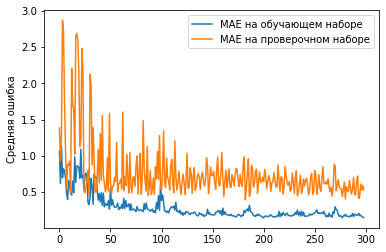

In [12]:


callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(1024, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(1024,dropout=0.3, return_sequences="True"))
model.add(LSTM(1024,dropout=0.3, return_sequences="True"))
model.add(LSTM(1024,dropout=0.3, return_sequences="True"))
#model.add(LSTM(1024,dropout=0.3, return_sequences="True"))
#model.add(LSTM(1024,dropout=0.3, return_sequences="True"))
model.add(Conv1D(512, 3, activation="linear"))
model.add(Conv1D(512, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val)


plt.plot(history.history['mae'][1:], 
         label='MAE на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='MAE на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [13]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

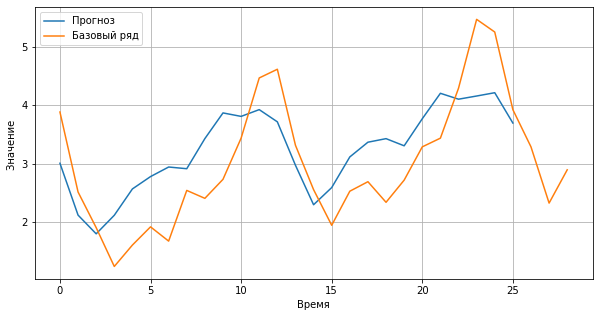

In [14]:
start = 0
step = 30
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[h+start:h+start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

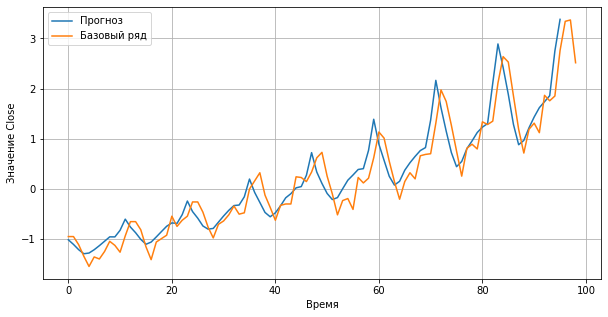

In [15]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[h+start:h+train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Модель верно подхватила тренд в данных. Увеличени слоев и невронов в них помогло улучшить качество , так же нужно было подобрать оптимальное колличество эпох и размер батча, 